## 主成分分析（PCA）

- 今、データ $\bf{X} = ( \boldsymbol{x}^1, \boldsymbol{x}^2, ... , \boldsymbol{x}^m )$
- $\boldsymbol{x}^i=(x_1^i,x_2^i)^\mathsf{T}$
- をノルム1の直線($||\boldsymbol{w}||=1$)、$\boldsymbol{w}=(w_1,w_2)^\mathsf{T}$ へ射影することを考える
- このベクトル$\boldsymbol{x}^i$を$\boldsymbol{w}$上へ射影した長さは、
- $z^i = \boldsymbol{w}^\mathsf{T} \boldsymbol{x}^i$　となる
- さて、この射影したデータの分散は定義より
- $s_z^2=\frac{1}{m}\Sigma_i (z^i-\bar{z})^2$
- ただし、$\bar{z}=\boldsymbol{w}^\mathsf{T} \bar{\boldsymbol{x}}$
- $s_z^2$を成分で書くと
- $s_z^2=\frac{1}{m}\Sigma_i \{ w_1(x_1^i-\bar{x}_1) + w_2(x_2^i-\bar{x}_2)\}^2$
- $=w_1^2 S_{x_1}^2+2w_1 w_2 S_{x_1 x_2}+w_2^2 S_{x_2}^2$
- $=(w_1,w_2)\Big(\begin{array}{cc}S_{x1}^2&S_{x_1 x_2}\\S_{x_1 x_2}&S_{x1}^2\end{array}\Big)(w_1,w_2)^\mathsf{T}$
- $=\boldsymbol{w}^\mathsf{T}\bf{S} \boldsymbol{w}$

#### $||\boldsymbol{w}||=1$の制約条件の下、分散を最大化したい→ラグランジュ未定乗数法の適用
- $\mathcal{L}(\boldsymbol{w},\lambda)=\boldsymbol{w}^\mathsf{T}\bf{S} \boldsymbol{w}-\lambda (1-\boldsymbol{w}^\mathsf{T}\boldsymbol{w})$
- これをwに関して微分＝０とすることで求める
- $\frac{\partial \mathcal{L}}{\partial \boldsymbol{w}}=2(\bf{S} \boldsymbol{w}-\lambda \boldsymbol{w})=0$
- この式は、共分散行列$\bf{S}$の固有ベクトル$\boldsymbol{w}$によって分散が最大化され、その固有値は$\lambda$であることを示す

#### 寄与率、累積寄与率
- $\frac{\lambda_k}{\Sigma_k \lambda_k}$
- 
- $\frac{\Sigma_{i=1}^k\lambda_i}{\Sigma_k \lambda_k}$


#### SSDSE-社会生活データセット
- 都道府県別・男女別の自由時間活動・生活時間データを集めたデータセット
- 各項目の値はそれをした人の数（単位は千人）
- https://www.nstac.go.jp/sys/files/kaisetsu-D-2023.pdf

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib
import seaborn as sns

In [2]:
URL = 'https://www.nstac.go.jp/sys/files/SSDSE-D-2023.csv'
df = pd.read_csv(URL, skiprows=[0, 2],
                  encoding='shift_jis')
columns = [
  'つり', '水泳', 'スキー・スノーボード', '登山・ハイキング',
  'サイクリング', 'ジョギング・マラソン',
  'ウォーキング・軽い体操', 'ヨガ'
 ]

df.loc[0:46, ['都道府県'] + columns]

,都道府県,つり,水泳,スキー・スノーボード,登山・ハイキング,サイクリング,ジョギング・マラソン,ウォーキング・軽い体操,ヨガ
0,北海道,8.8,4.7,8.3,6.1,7.5,9.7,40.6,5.0
1,青森県,9.4,3.2,4.4,4.0,4.0,8.1,32.0,2.7
2,岩手県,9.4,5.2,4.0,5.7,4.4,9.2,35.8,3.6
3,宮城県,9.1,5.9,3.9,6.4,6.5,11.5,40.9,4.7
4,秋田県,8.0,4.3,5.0,4.7,5.1,9.4,35.7,2.8
5,山形県,8.3,3.8,4.9,7.7,5.0,9.6,36.2,3.5
6,福島県,7.0,4.1,3.4,6.4,6.1,8.6,37.4,3.5
7,茨城県,6.6,4.9,2.5,8.8,9.2,11.5,45.2,5.0
8,栃木県,6.3,4.8,3.7,8.5,7.1,9.7,39.7,3.7
9,群馬県,5.5,4.0,4.5,8.3,7.9,10.8,45.8,4.3


In [4]:
activity_df = df.loc[0:46, columns]

In [5]:
activity_df

,つり,水泳,スキー・スノーボード,登山・ハイキング,サイクリング,ジョギング・マラソン,ウォーキング・軽い体操,ヨガ
0,8.8,4.7,8.3,6.1,7.5,9.7,40.6,5.0
1,9.4,3.2,4.4,4.0,4.0,8.1,32.0,2.7
2,9.4,5.2,4.0,5.7,4.4,9.2,35.8,3.6
3,9.1,5.9,3.9,6.4,6.5,11.5,40.9,4.7
4,8.0,4.3,5.0,4.7,5.1,9.4,35.7,2.8
5,8.3,3.8,4.9,7.7,5.0,9.6,36.2,3.5
6,7.0,4.1,3.4,6.4,6.1,8.6,37.4,3.5
7,6.6,4.9,2.5,8.8,9.2,11.5,45.2,5.0
8,6.3,4.8,3.7,8.5,7.1,9.7,39.7,3.7
9,5.5,4.0,4.5,8.3,7.9,10.8,45.8,4.3


In [6]:
# 特徴量の要約
activity_df.describe()

,つり,水泳,スキー・スノーボード,登山・ハイキング,サイクリング,ジョギング・マラソン,ウォーキング・軽い体操,ヨガ
count,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000
mean,8.563830,5.061702,2.904255,6.795745,6.627660,9.991489,41.312766,4.627660
std,1.810768,1.076135,1.966785,1.778612,1.921017,1.544109,3.955602,1.107033
min,5.000000,3.200000,0.200000,2.400000,2.700000,7.300000,32.000000,2.700000
25%,7.100000,4.350000,1.250000,5.650000,5.550000,9.000000,38.400000,3.900000
50%,8.500000,4.900000,2.700000,6.400000,6.400000,9.800000,41.100000,4.500000
75%,9.850000,5.650000,4.150000,8.300000,7.550000,10.750000,44.250000,5.300000
max,12.200000,8.600000,8.300000,9.800000,14.400000,15.300000,52.300000,8.400000


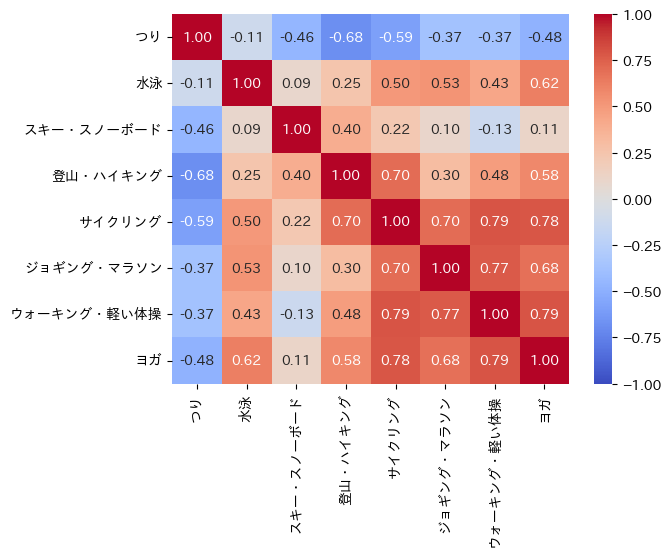

In [9]:
# 特徴量間のペア相関
sns.heatmap(activity_df.corr(), cmap='coolwarm',
              annot=True, fmt='.2f', vmin=-1, vmax=1)
plt.show()

In [7]:
# 特徴量の標準化（平均０、偏差１に変換すること）
X = activity_df.values
X = (X - X.mean(axis=0)) / X.std(axis=0)

### Scikit-learnのPCAクラスによる主成分分析の実行

In [26]:
from sklearn.decomposition import PCA

k = 2
model = PCA(n_components=k)
model.fit(X)
X_reduced = model.transform(X)

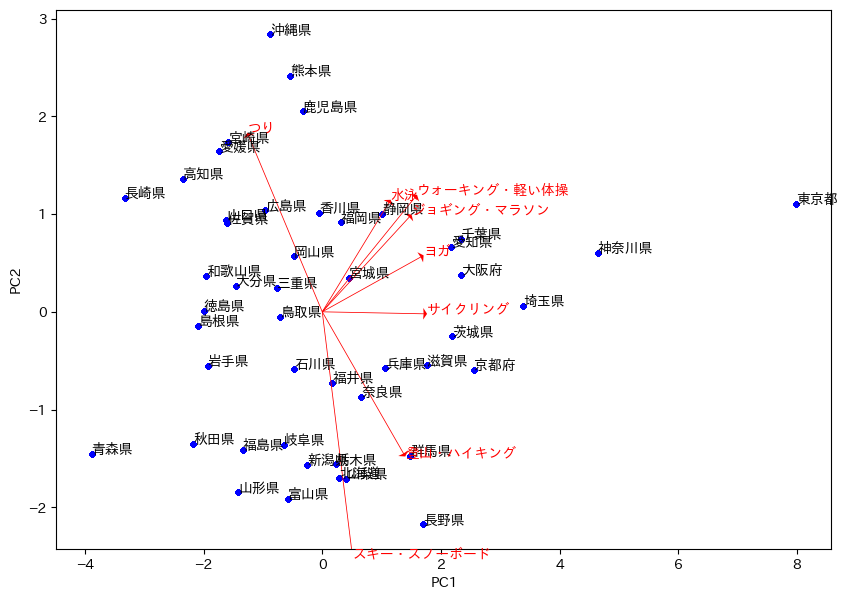

In [15]:
prefectures = df.loc[0:46, '都道府県']

plt.figure(figsize=(10,7))

for i, label in enumerate(prefectures):
  plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c='blue', s=10)
  plt.annotate(label, (X_reduced[i, 0], X_reduced[i, 1]))

for i, label in enumerate(columns):
  x, y = 4 * model.components_[:,i]
  plt.quiver(0, 0, x, y, angles='xy', scale_units='xy', scale=1, color='red', width=0.001, headwidth=15)
  plt.text(x, y, label, c='red')

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

### 寄与率、累積寄与率

In [27]:
# 第１主成分の寄与率
print(model.explained_variance_ratio_[0])
# 第２主成分までの累積寄与率
print(np.sum(model.explained_variance_ratio_))

0.5549182146752434
0.7452012331949545


### SVDでの実行

In [42]:
from sklearn.decomposition import TruncatedSVD

model1 = TruncatedSVD(n_components=2,n_iter=1)
model1.fit(X)
X_reduced = model1.transform(X)

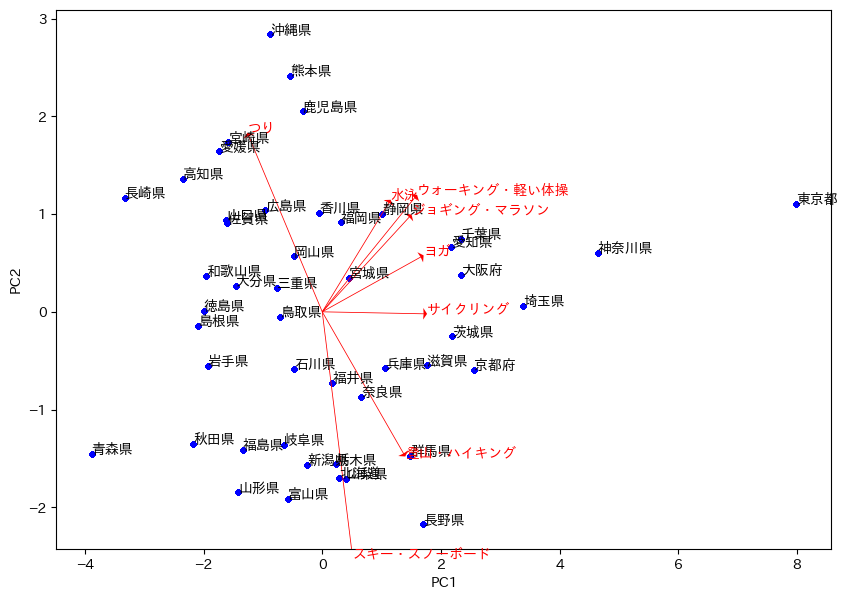

In [43]:
prefectures = df.loc[0:46, '都道府県']

plt.figure(figsize=(10,7))

for i, label in enumerate(prefectures):
  plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c='blue', s=10)
  plt.annotate(label, (X_reduced[i, 0], X_reduced[i, 1]))

for i, label in enumerate(columns):
  x, y = 4 * model1.components_[:,i]
  plt.quiver(0, 0, x, y, angles='xy', scale_units='xy', scale=1, color='red', width=0.001, headwidth=15)
  plt.text(x, y, label, c='red')

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

#### SVDによる行列の復元

In [46]:
# 元の行列
X[0:3,:]

array([[ 0.13183549, -0.33974596,  2.77309384, -0.3954019 ,  0.45901287,
        -0.19081594, -0.18213958,  0.33997699],
       [ 0.46676889, -1.74869247,  0.76872436, -1.58886268, -1.38263634,
        -1.2382144 , -2.37977597, -1.76010947],
       [ 0.46676889,  0.12990287,  0.563148  , -0.62272776, -1.17216214,
        -0.51812796, -1.40872733, -0.9383365 ]])

In [56]:
X.shape

(47, 8)

In [47]:
X_reduced.shape

(47, 2)

In [48]:
model1.components_.shape

(2, 8)

In [50]:
sigma = np.diag(model1.singular_values_)

In [52]:
X_restored = np.dot(np.dot(X_reduced,sigma),model1.components_)

In [58]:
X - X_restored

array([[ 7.99110338e+00,  2.60212864e+00, -6.81583168e+00,
        -7.13281423e+00, -1.41456222e+00,  1.84866652e+00,
         2.48825383e+00,  6.72188264e-01],
       [-1.16230480e+01,  1.79417125e+01,  2.25942113e-01,
         1.35021674e+01,  2.33498637e+01,  2.29450698e+01,
         2.37237609e+01,  2.39928639e+01],
       [-6.18996932e+00,  9.50845280e+00,  1.18831233e+00,
         7.40089648e+00,  1.11255218e+01,  1.11466440e+01,
         1.11386882e+01,  1.16545564e+01],
       [ 9.95039253e-01, -1.91493698e+00,  1.53401504e+00,
        -1.39966867e+00, -2.90639582e+00, -2.17458525e+00,
        -3.56540171e+00, -3.11790333e+00],
       [-4.97818299e+00,  1.15929324e+01, -2.10883465e+00,
         5.55007664e+00,  1.29890764e+01,  1.42585249e+01,
         1.45147864e+01,  1.33767631e+01],
       [ 5.25298120e-01,  9.19176181e+00, -6.18932777e+00,
         1.91376237e+00,  8.11929055e+00,  1.13415253e+01,
         1.15539727e+01,  9.98027672e+00],
       [-1.49884520e+00,  8.068548

## LDA(Latent Dirichlet Allocation) 潜在的ディリクレ配分法

In [1]:
%load_ext jupyter_tikz

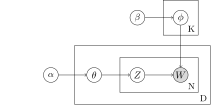

In [109]:
%%tikz
\usetikzlibrary{positioning, fit, backgrounds}

\begin{tikzpicture}[
    observed/.style={circle, draw=black, fill=gray!30, minimum size=15pt, inner sep=0pt},
    latent/.style={circle, draw=black, fill=white, minimum size=15pt, inner sep=0pt},
    plate/.style={rectangle, draw=black, inner sep=5pt, rounded corners=0pt},
    const/.style={circle, draw=black, fill=white, minimum size=15pt, inner sep=0pt, font=\small}
]

% ノード
\node[const] (alpha) {$\alpha$};
\node[latent, right=of alpha] (theta) {$\theta$};
\node[latent, right=of theta] (z) {$Z$};
\node[observed, right=of z] (w) {$W$};
\node[latent, above=1.5cm of w] (phi) {$\phi$};
\node[const, left=of phi] (beta) {$\beta$};

% 矢印
\draw[->] (alpha) -- (theta);
\draw[->] (theta) -- (z);
\draw[->] (beta) -- (phi);
\draw[->] (z) -- (w);
\draw[->] (phi) -- (w);

% プレート：単語 N
\node[plate, fit=(z)(w), inner sep=10pt] (plateN) {};
% プレート：文書 M
\node[plate, fit=(theta)(plateN), inner sep=12pt] (plateD) {};
% プレート：トピック K
\node[plate, fit=(phi), inner sep=10pt] (plateK) {};
% 右下にラベルKをノードとして配置
\node[anchor=south east, font=\small] at (plateK.south east) {K};
\node[anchor=south east, font=\small] at (plateN.south east) {N};
\node[anchor=south east, font=\small] at (plateD.south east) {D};

\end{tikzpicture}

- LDAの生成確率
- $P(\mathbf{w} \mid \alpha, \beta) =
\sum_{\phi} P(\phi \mid \beta) \,
\prod_{d=1}^{D} \sum_{\theta_d} P(\theta_d \mid \alpha)
\left(
\prod_{n=1}^{N_d}
\sum_{z_{d,n}=1}^{K} P(z_{d,n} \mid \theta_d) \,
P(w_{d,n} \mid \phi_{z_{d,n}})
\right)$
- $p(\mathbf{w} \mid \alpha, \beta) =
\int p(\phi \mid \beta) \,
\prod_{d=1}^{D} \int p(\theta_d \mid \alpha)
\left(
\prod_{n=1}^{N_d}
\sum_{z_{d,n}=1}^{K} p(z_{d,n} \mid \theta_d) \,
p(w_{d,n} \mid \phi_{z_{d,n}})
\right)
\, d\theta_d \, d\phi$
- 求めたい事後分布
- $P(\mathbf{\theta},\mathbf{\phi}|\mathbf{w},\alpha,\beta)$

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [phi, theta]
>BinaryGibbsMetropolis: [z_0, z_1, z_2]


Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 7 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


array([[<Axes: title={'center': 'phi'}>, <Axes: title={'center': 'phi'}>],
       [<Axes: title={'center': 'theta'}>,
        <Axes: title={'center': 'theta'}>]], dtype=object)

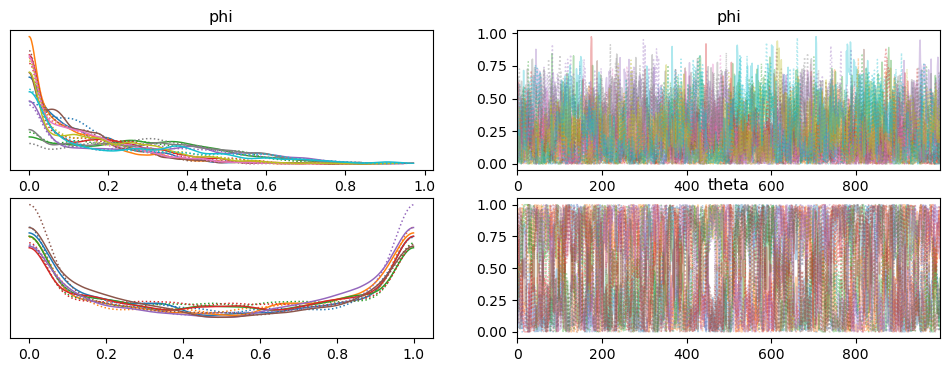

In [3]:
import pymc as pm
import numpy as np
import pandas as pd
import arviz as az

# データ（例として文書ごとの単語出現を数値化したBag-of-Words行列）
# 文書×単語行列（D=3, V=5）
documents = np.array([
    [1, 2, 3, 0, 0],
    [0, 0, 2, 3, 1],
    [1, 0, 1, 0, 4]
])

D, V = documents.shape
K = 2

alpha = np.ones(K) * 0.5  # 文書トピック分布のディリクレハイパーパラメータ
beta = np.ones(V) * 0.5   # トピック単語分布のディリクレハイパーパラメータ

with pm.Model() as lda_model:
    # トピック単語分布 φ (K×V)
    phi = pm.Dirichlet('phi', a=beta, shape=(K, V))

    # 文書ごとのトピック分布 θ (D×K)
    theta = pm.Dirichlet('theta', a=alpha, shape=(D, K))

    # 各文書のトピック割当（潜在変数） z
    z = []
    w_obs = []
    for d in range(D):
        # 文書 d の単語数
        N_d = int(documents[d].sum())
        # トピック z をサンプリング
        z_d = pm.Categorical(f'z_{d}', p=theta[d], shape=N_d)
        z.append(z_d)

        # 生成される単語の分布はトピック z_d に基づく
        w_d = pm.Categorical(
            f'w_{d}',
            p=phi[z_d],
            observed=np.repeat(np.arange(V), documents[d])
        )
        w_obs.append(w_d)

    # サンプリング
    trace = pm.sample(1000, tune=1000, target_accept=0.9, chains=2, random_seed=42)

# トレースの確認
az.plot_trace(trace, var_names=['phi', 'theta'])

In [12]:
# 実際MCMCでやると遅いので普通は使わないので、gensimのライブラリを利用してみる（sklearn.decompositionにもある）

In [14]:
from sklearn.feature_extraction.text import CountVectorizer
from gensim.corpora.dictionary import Dictionary
from gensim.models import LdaModel
from tqdm import tqdm
import numpy as np
import pickle as pkl

In [25]:
import requests
from bs4 import BeautifulSoup
import re

In [26]:
def getText(url):
    # 青空文庫からテキストデータを取得
    response = requests.get(url)
    soup = BeautifulSoup(response.content, 'html.parser')
    text = soup.find('div', {'class': 'main_text'}).text
    cleaned_text = re.sub(r'[\r\n\u3000]', '', text)

    return cleaned_text

In [27]:
# 山月記
titleurl = "https://www.aozora.gr.jp/cards/000119/files/624_14544.html"

In [28]:
c0 = getText(titleurl)

In [29]:
# 智恵子抄
titleurl = "https://www.aozora.gr.jp/cards/001168/files/46669_25695.html"

In [30]:
c1 = getText(titleurl)

In [31]:
# 羅生門
titleurl = "https://www.aozora.gr.jp/cards/000879/files/127_15260.html"

In [32]:
c2 = getText(titleurl)

In [33]:
import janome
from janome.tokenizer import Tokenizer

In [79]:
t = Tokenizer()

In [80]:
c0ws = list(t.tokenize(c0[0:5000], wakati=True))
c1ws = list(t.tokenize(c1[0:5000], wakati=True))
c2ws = list(t.tokenize(c1[0:5000], wakati=True))

In [81]:
def wordfilter(ws):
    wsf = []
    for w in ws:
        if len(set(w)) == 1:
            continue
        else:
            wsf.append(w)

    return wsf

In [82]:
c0wsf = wordfilter(c0ws)
c1wsf = wordfilter(c1ws)
c2wsf = wordfilter(c2ws)

In [83]:
corpus = [c0wsf,c1wsf,c2wsf]

In [84]:
corpus_dictionary = Dictionary(corpus)

In [85]:
wid_corpus = [corpus_dictionary.doc2bow(ws) for ws in corpus]

In [86]:
#wid_corpus

In [102]:
num_topics = 8
lda = LdaModel(wid_corpus, id2word=corpus_dictionary, num_topics=num_topics,alpha=0.01)

In [103]:
rows = []
for t in range(num_topics):
    word = []
    for i, prob in lda.get_topic_terms(t, topn=15):
        word.append(corpus_dictionary.id2token[int(i)])
    rows.append(pd.Series(word, name=f'topic{t+1}'))

# DataFrame化
df = pd.DataFrame(rows)

# 行インデックス名に置換（任意）
df.index = [f'topic{t+1}' for t in range(num_topics)]

In [104]:
df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
topic1,ない,いけ,その,やう,ある,あなた,それ,から,もの,こと,こころ,自分,われ,なれ,人間
topic2,ない,あなた,いけ,こころ,ある,それ,わが,なれ,もの,その,やう,から,なり,われ,大正
topic3,ない,あなた,こころ,いけ,ある,から,その,わが,やう,なれ,彼等,それ,われ,もの,より
topic4,ない,あなた,から,その,いけ,われ,やう,もの,ある,こころ,それ,わが,たる,人間,ゐる
topic5,ない,ある,あなた,その,それ,自分,こころ,ゐる,もの,から,いけ,やう,こと,なれ,われ
topic6,ない,から,いけ,あなた,その,それ,ある,自分,人間,もの,こころ,われ,なっ,こと,やう
topic7,ない,から,自分,その,いけ,われ,それ,こころ,あなた,こと,ゐる,やう,なる,ある,なれ
topic8,ない,その,から,あなた,こころ,やう,ある,われ,こと,もの,いけ,なれ,自分,なり,ページ


In [105]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

In [106]:
pyLDAvis.enable_notebook()

vis = gensimvis.prepare(
      lda, wid_corpus, corpus_dictionary, n_jobs = 1, sort_topics = False
      )

pyLDAvis.display(vis)

In [107]:
import matplotlib.pyplot as plt
import japanize_matplotlib

from wordcloud import WordCloud
from PIL import Image
import matplotlib.pyplot as plt

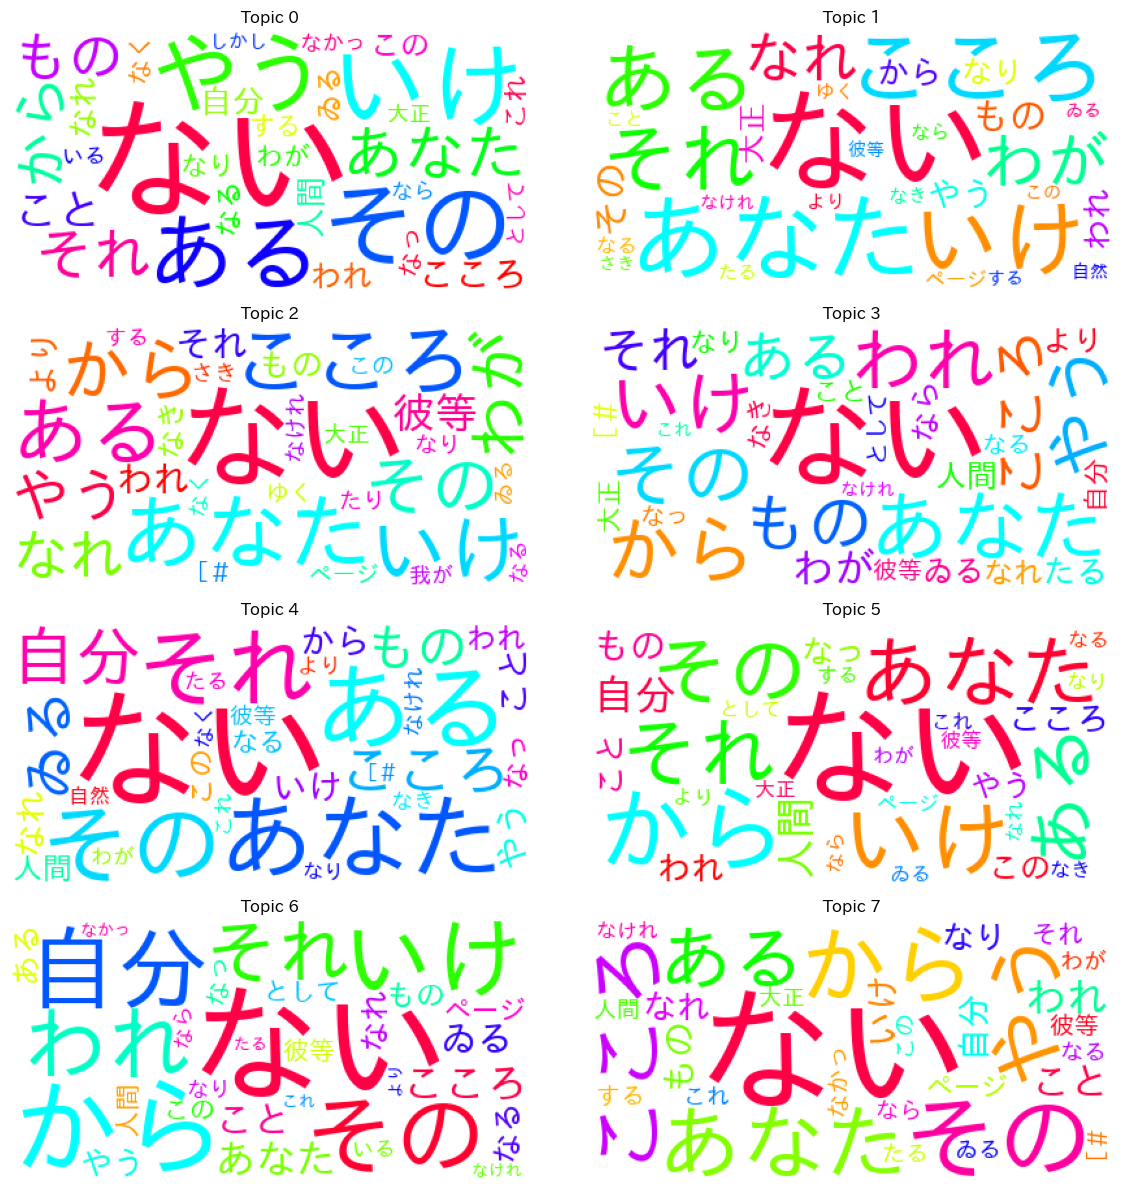

In [108]:
fig, axs = plt.subplots(ncols=2, nrows=4, figsize=(12,12))
axs = axs.flatten()

def color_func(word, font_size, position, orientation, random_state, font_path):
    return 'darkturquoise'

font_path = '/usr/share/fonts/truetype/fonts-japanese-gothic.ttf'
#ワードクラウドを楕円形にするためのイメージをmaskとして取得します。
#mask = np.array(Image.open("/content/phpYSbfIJ.png"))

for i, t in enumerate(range(lda.num_topics)):
    x = dict(lda.show_topic(t, 30))
    im = WordCloud(
        font_path=font_path,
        background_color='white',
        colormap="hsv",
        mask=None,
        random_state=0
    ).generate_from_frequencies(x)
    axs[i].imshow(im)
    axs[i].axis('off')
    axs[i].set_title('Topic '+str(t))

plt.tight_layout()
plt.show()